# LAB 7: Error analysis

Objectives
* Construct a  linear text classifier using SGDClassifier
* Evaluate its performance and categorize the errors that it makes
* Eaxmine model's coefficients and decision function values
* Interpret model results using LIME

In [2]:
import numpy as np
import pandas as pd
from cytoolz import *
from tqdm.auto import tqdm

tqdm.pandas()

---

## Load data

In [3]:
train = pd.read_parquet("s3://ling583/lab7-train.parquet", storage_options={"anon":True})
test = pd.read_parquet("s3://ling583/lab7-test.parquet", storage_options={"anon":True})

In [4]:
import cloudpickle
from sklearn.metrics import classification_report, f1_score, plot_confusion_matrix

In [5]:
sgd = cloudpickle.load(open("sgd.model", "rb"))

In [6]:
predicted = sgd.predict(test["text"])
print(classification_report(test["topics"], predicted))

              precision    recall  f1-score   support

        GJOB       0.97      0.94      0.96       573
        GPOL       0.94      0.96      0.95      1853
        GSPO       1.00      0.99      1.00      1410
        GVIO       0.92      0.91      0.92       928

    accuracy                           0.96      4764
   macro avg       0.96      0.95      0.96      4764
weighted avg       0.96      0.96      0.96      4764



---

## Decision function

In [7]:
labels = sgd.named_steps['sgdclassifier'].classes_
scores = sgd.decision_function(test["text"])

In [8]:
labels

array(['GJOB', 'GPOL', 'GSPO', 'GVIO'], dtype='<U4')

In [9]:
scores[0,:]
# The first entry, looks like it was classified as GJOB since that has the highest value

array([-0.00450741, -0.82905066, -0.97918263, -0.94305605])

In [10]:
# Lets look at what the data source has it tagged as 
test['topics'].iloc[0]

'GJOB'

In [11]:
test['text'].iloc[0]

"Canada's Terra Nova partners set labor agreement. A new labor agreement covering future operations at Newfoundland's Bull Arm construction site, where some work on the Terra Nova oil project is expected to be done, was completed on Monday, Terra Nova's partners said. The deal, signed by PCL Industrial Constructors Inc and the Newfoundland and Labrador Building and Construction Trades Council, will allow Bull Arm to be considered for the building of some of the oil platform's topsides. The key part of the deal was the formation of a single union representing workers at the site, the firms said."

In [12]:
highest = scores.max(axis=1)

In [13]:
highest[0]

-0.004507405342632054

In [14]:
# The instance that has the highest score in the whole dataset
highest.argmax()

3436

In [19]:
# These are the scores for that highest scoring article; the most solidly in one category
scores[3436]

array([-2.90364538,  4.88927742, -2.49841272, -3.91232828])

In [20]:
# what category was that article?
test['topics'].iloc[3436]

'GPOL'

In [21]:
# Take a look at the text to see what made it score that high in politics
test['text'].iloc[3436]

"FRENCH ELECTION - HOW THEY VOTE. About 39 million French voters are entitled to vote in Sunday's first round of a two-stage election to choose a new National Assembly or lower house of parliament. President Jacques Chirac used his constitutional power to dissolve the Assembly on April 21 and called a snap election, 10 months ahead of schedule, for May 25 and June 1. The president, who appoints the prime minister and cabinet, may not dissolve parliament again in the first year of a new legislature. Some 6,389 candidates are vying for the 577 seats in single-member constituencies, the Interior Ministry said. The record is 29 candidates in a single electoral district in central Paris. A candidate who wins more than 50 percent of votes cast on the first ballot is elected without a runoff. Otherwise, any candidate who polls 12.5 percent of the total of registered voters has the right to contest the second ballot. The person who wins the most votes on the runoff is elected, even if he or sh

In [22]:
# find the article where the highest value within the article is the lowest for that category (GJOB, JPOL, etc)
highest.argmin()

1824

In [23]:
# looks like we assigned it to the GPOL category
scores[1824]

array([-0.71236882, -0.49888033, -0.85635185, -0.61739103])

In [24]:
# it is actually a political article
test['topics'].iloc[1824]

'GPOL'

In [25]:
test['text'].iloc[1824]

'KKK says membership is growing in the United States. The Ku Klux Klan\'s membership drive has successfully crossed the Mason-Dixon Line and is now concentrating on building membership through the nation\'s prison population, Klan leaders said on Saturday. Speaking before a rally in Pittsburgh, the Klan\'s top two national officers denied that the organisation\'s strongholds were limited to the Deep South, as typically perceived, adding that Texas was the next target for major Klan recruitment. "That (strength limited to the South) is something the media tries to portray," said Jeff Berry, Imperial Wizard of the Klan. "Indiana always has been the strongest state for the Klan. We\'ve had rallies in Indiana where our membership numbered 300,000 strong." Berry, who claimed his position in the Klan was akin to being president of the United States, said membership in Indiana numbers around 8,000. He would not disclose totals from other states, but said Pennsylvania has the second-largest nu

In [26]:
# Each row is a single test example, columns are the 4 classes
scores[0:5,:]

array([[-0.00450741, -0.82905066, -0.97918263, -0.94305605],
       [-1.52736048,  1.30122739, -1.55517604, -1.3648672 ],
       [-1.31646513,  1.22331187, -1.55907506, -1.25159479],
       [-1.42591414, -1.31872884,  1.64954134, -1.56118183],
       [ 0.61588648, -0.66133191, -1.15336902, -2.22780685]])

In [27]:
# we want to see how close the highest and second highest scores are for each instance. Start by sorting the arrays
# The issue here is that we lose the context of what score is associated to what category
scores.sort(axis=1)
scores[0:5,:]

array([[-0.97918263, -0.94305605, -0.82905066, -0.00450741],
       [-1.55517604, -1.52736048, -1.3648672 ,  1.30122739],
       [-1.55907506, -1.31646513, -1.25159479,  1.22331187],
       [-1.56118183, -1.42591414, -1.31872884,  1.64954134],
       [-2.22780685, -1.15336902, -0.66133191,  0.61588648]])

In [28]:
# Calculate the margins for the scores, That is the difference betwen the top and second score
margin = scores[:,3]-scores[:,2]

In [29]:
margin.max(), margin.min()

(7.387690146323818, 0.00539294662073464)

In [30]:
# We just want to see those where the margin is large
print(classification_report(test["topics"][margin > 5], predicted[margin > 5]))

# When the margin is large, we are 100% confident in our classification decision, but we only have 93 instances there. 

              precision    recall  f1-score   support

        GJOB       1.00      1.00      1.00        15
        GPOL       1.00      1.00      1.00        62
        GSPO       1.00      1.00      1.00         7
        GVIO       1.00      1.00      1.00         9

    accuracy                           1.00        93
   macro avg       1.00      1.00      1.00        93
weighted avg       1.00      1.00      1.00        93



In [31]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'F1')

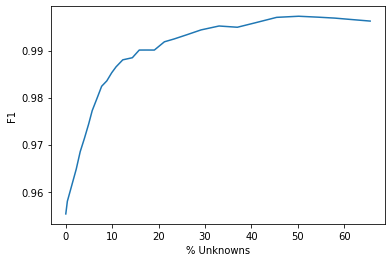

In [32]:
thresh = np.linspace(-2, 3, 50)
x = [100*(1-sum(margin > t)/len(margin)) for t in thresh]
y = [f1_score(test["topics"][margin > t], predicted[margin > t], average="macro") for t in thresh]
plt.plot(x, y)
plt.xlabel('% Unknowns')
plt.ylabel('F1')

In [33]:
print(classification_report(test["topics"][margin > 1.75], predicted[margin > 1.75]))

              precision    recall  f1-score   support

        GJOB       1.00      0.99      0.99       425
        GPOL       0.99      0.99      0.99      1424
        GSPO       1.00      1.00      1.00      1297
        GVIO       0.98      0.99      0.98       626

    accuracy                           0.99      3772
   macro avg       0.99      0.99      0.99      3772
weighted avg       0.99      0.99      0.99      3772



**TO DO:** Summarize your results for this section. What could we do if we wanted to make label as many examples as possible while still keeping F1 above 0.99?

The article that had the highest category score in this model conveniently had very low scores for the other 3 categories with a margin of about 7.79. When keeping only those articles with a margin greater than 5, there was an accuracy of 100% but we only return 93 articles or about 1.9% of all articles. When dropping the margin to 1.75, that netted us 3772 articles or about 79% of the total while keeping 99% accuracy.

If we wanted to keep our F1 above 99% while maximizing our supporting articles, we could adjust the minimum margin required until it meets our needs. GVIO is the category that gives us the most trouble with this, thus pushing our minimum margin higher and our supporting articles lower. At minimum margin 2.2, all categories are at 1.00 F1 score except for GVIO which is at 0.99. GVIO doesn't reach F1 1.00 until minimum margin of 4.0. 

With the minimum margin at 2.2 we get 3145 supporting articles while at 4.0 (which we need in order to get GVIO to F1 1.00) we only get 482 articles.

In [64]:
print("margin > 2.2\n", classification_report(test["topics"][margin > 2.2], predicted[margin > 2.2])) # optimal for all but GVIO
print()
print("margin > 3.9\n",classification_report(test["topics"][margin > 3.9], predicted[margin > 3.9])) # to show that GVIO is still at 0.99
print()
print("margin > 4.0\n",classification_report(test["topics"][margin > 4], predicted[margin > 4])) # optimal for all categories

margin > 2.2
               precision    recall  f1-score   support

        GJOB       1.00      1.00      1.00       351
        GPOL       1.00      1.00      1.00      1209
        GSPO       1.00      1.00      1.00      1084
        GVIO       0.99      0.99      0.99       501

    accuracy                           1.00      3145
   macro avg       1.00      1.00      1.00      3145
weighted avg       1.00      1.00      1.00      3145


margin > 3.9
               precision    recall  f1-score   support

        GJOB       1.00      1.00      1.00        67
        GPOL       0.99      1.00      1.00       332
        GSPO       1.00      1.00      1.00        67
        GVIO       1.00      0.98      0.99        90

    accuracy                           1.00       556
   macro avg       1.00      0.99      1.00       556
weighted avg       1.00      1.00      1.00       556


margin > 4.0
               precision    recall  f1-score   support

        GJOB       1.00      1.

---

## Model parameters

In [65]:
coef = sgd.named_steps['sgdclassifier'].coef_
labels, coef

(array(['GJOB', 'GPOL', 'GSPO', 'GVIO'], dtype='<U4'),
 array([[-0.25214425, -0.02430108,  0.12891282, ...,  0.        ,
         -0.00314414, -0.01129438],
        [ 0.29372241, -0.11145409, -0.04951688, ...,  0.        ,
          0.        ,  0.00798656],
        [ 0.1211969 ,  0.04325198,  0.04356682, ...,  0.        ,
          0.        ,  0.        ],
        [-0.33690344,  0.        ,  0.06254737, ...,  0.        ,
          0.        , -0.01437185]]))

In [66]:
coef.shape

(4, 27939)

In [67]:
vocab = sgd.named_steps['countvectorizer'].get_feature_names()

In [68]:
# GJOB
coef[0,:].argmax()

13100

In [69]:
coef[0,13100]

4.522631071356675

In [70]:
vocab[13100]

'jobs'

This means that for the GJOB category, each occurance of the word "jobs" gives a weight of 4.522631071356675

In [71]:
ranked = np.argsort(coef, axis=1)
for i, label in enumerate(labels):
    print(label)
    for j in concat([range(-1, -11, -1), range(10, 0, -1)]):
        print(f'  {vocab[ranked[i,j]]:15s} {coef[i, ranked[i,j]]:6.3f}')
    print()

GJOB
  jobs             4.523
  strike           4.312
  employees        3.807
  workers          3.733
  unemployment     3.712
  company          2.720
  union            2.695
  unions           2.550
  wage             2.441
  wages            2.425
  welfare         -0.984
  political       -1.006
  parliament      -1.007
  war             -1.085
  clinton         -1.115
  spending        -1.133
  tax             -1.198
  security        -1.299
  budget          -1.478
  election        -1.737

GPOL
  election         3.793
  party            3.154
  elections        2.961
  parliament       2.813
  minister         2.794
  president        2.590
  vote             2.465
  budget           2.212
  clinton          2.042
  yeltsin          1.950
  rebels          -2.148
  company         -2.170
  bombing         -2.227
  strike          -2.471
  unions          -2.561
  employees       -2.612
  soccer          -2.715
  protest         -2.967
  workers         -3.146
  unemployment

In [72]:
from kwic import kwic

In [73]:
kwic('newsroom', train['text'])

4,l Amendment would appear on the state ballot next year. ((-- San Francisco,newsroom,", 415-677-2511))"
5,be called but it need not necessarily result in a work stoppage. -- Warsaw,Newsroom,+48 22 653 9700
14,"0 tonnes) and wheat ship (9,125 tonnes) --Caroline Bulloch, Rio de Janeiro",newsroom,", 5521 5074151"
15,the top tax rate and proposed taxes on night- and holiday shifts. -- Bonn,newsroom,", 49-228-26097150"
21,"t had so far sought to put the new law into effect. --Mark John, Frankfurt",Newsroom,+49 69 756525
37,"p of the conservative New Democracy party. --Dimitris Kontogiannis, Athens",Newsroom,+301 3311812-4
52,saying they would vote compared to 64.6 percent of CSSD voters. -- Prague,Newsroom,42-2-2423-0003
56,nment and a widepread perception that bureaucrats were corrupt. -- Vilnius,newsroom,", +370 2 22 35 17"
76,"on on the person likely to replace Malakis. --George Georgiopoulos, Athens",Newsroom,+301 3311812-4
83,"A promise without a cost is nearly always a lie."" -- Mike Peacock, London",Newsroom,+44 171 542 5109


In [74]:
kwic('zaire', train['text'])

32,rebels assure mining firms of continuity. Rebels on the advance in eastern,Zaire,"will leave mining concessions untouched in the areas they control, provide"
33,"Kabila, Mobutu agree to",Zaire,talks Wednesday - UN. Zaire's beleaguered president Mobutu Sese Seko and r
33,"Kabila, Mobutu agree to Zaire talks Wednesday - UN.",Zaire,'s beleaguered president Mobutu Sese Seko and rebel leader Laurent Kabila h
33,rt of a South African attempt to mediate a peaceful transition of power in,Zaire,. Kabila's rebels now control three quarters of the country and Mobutu has
38,ops who were trapped at the airport and had threatening to rain rockets on,Zaire,"'s second city. A day after the rebel takeover, residents looted army premi"
38,in on from all sides. Disciplined columns of Kabila's forces marched into,Zaire,'s copper capital and economic powerhouse on Wednesday morning. The army la
86,S.Africa to host,Zaire,"government, rebels for talks. Zaire's warring sides have asked President N"
86,"S.Africa to host Zaire government, rebels for talks.",Zaire,'s warring sides have asked President Nelson Mandela of South Africa to hos
86,"s,"" Mandela said. He said South Africa would send air transport to pick up",Zaire,'s rebel leader Laurent Kabila from Kigali in Rwanda and that he hoped the
86,s in Cape Town with regional leaders on how to defuse growing conflicts in,Zaire,"and in southern Africa. Fighting in Zaire has intensified, with ailing Pre"


**TO DO:** What can you conclude about the model from looking at the coefficients? Is there evidence of overfitting? How could we improve the results?

For the most part, the coefficients make sense given the categories they are in and the values that they carry. A few curious ones stood out to me. The first is that 'union' and 'unions' are assigned different values though they mean basically the same thing in the political context where they are used. Another is that in the political category, 'protest' carries a negative value, where one would assume that protests are inherently political. Also, in the violence/war category, 'strike' has a very negative score even though in most modern war articles, strike is a very common term. Perhaps these are simply due to the age of the dataset. In the same vein as those terms possibly being a product of the article's times, as mentioned in the video, 'Clinton', 'Yeltsin', and 'Zaire' all appear in the categories as a product of the events occuring around the time of the articles writing and are not due the inherent properties of those names.